In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cd drive/MyDrive/NST/

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load images

In [4]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("drive/MyDrive/NST/img/style.jpg")
content_img = image_loader("drive/MyDrive/NST/img/content.jpg")

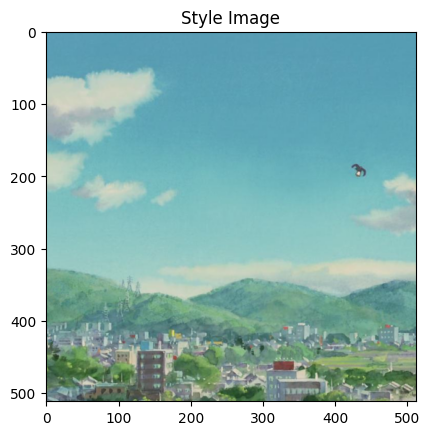

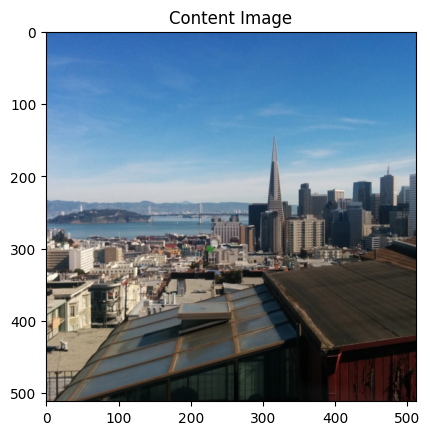

In [14]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, title=None):
    image = tensor.clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss

In [18]:
def gram_matrix(input):
    b, c, h, w = input.size()

    features = input.view(b * c, h * w)

    G = torch.mm(features, features.t())  # compute the gram product

    return G.div(b * c * h * w) #normalization

class ContentLoss(nn.Module):
    """A class for content loss computation, inheriting from nn.Module."""

    def __init__(self, target_content):
        """Initializes the ContentLoss instance.

        Args:
            target_content (Tensor): The target content for loss calculation.
        """
        super().__init__()  # Initialize the superclass nn.Module
        # Detach the target content to prevent it from participating in gradient updates
        self.target_content = target_content.detach()

    def forward(self, input_content):
        """Defines the forward pass for the content loss calculation.

        Args:
            input_content (Tensor): The input content to compare against the target.

        Returns:
            Tensor: The input content, passed through unmodified.
        """
        # Calculate the mean squared error loss between input and target content
        self.loss = F.mse_loss(input_content, self.target_content)
        return input_content

class StyleLoss(nn.Module):
    """A class for style loss computation, inheriting from nn.Module."""

    def __init__(self, target_style):
        """Initializes the StyleLoss instance.

        Args:
            target_style (Tensor): The target style feature for loss calculation.
        """
        super().__init__()  # Initialize the superclass nn.Module
        # Compute the gram matrix of the target style and detach it from gradient updates
        self.target_style = gram_matrix(target_style).detach()

    def forward(self, input_style):
        """Defines the forward pass for the style loss calculation.

        Args:
            input_style (Tensor): The input style to compare against the target.

        Returns:
            Tensor: The input style, passed through unmodified.
        """
        # Calculate the gram matrix of the input style
        G = gram_matrix(input_style)
        # Calculate the mean squared error loss between the input and target style representations
        self.loss = F.mse_loss(G, self.target_style)
        return input_style



## Model

In [26]:
# Initialize the VGG19 model to extract features. Set it to evaluation mode.
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
cnn = cnn.to(device)

# Define normalization mean and standard deviation for image preprocessing
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std, device='cuda'):
        """Initialize the normalization module.

        Args:
            mean (Tensor): The mean for normalization.
            std (Tensor): The standard deviation for normalization.
            device (str, optional): The device to run the module on. Defaults to 'cpu'.
        """
        super(Normalization, self).__init__()
        # Use .clone().detach() to avoid affecting the original tensor's computational graph
        # Move the tensors to the specified device
        self.mean = mean.clone().detach().view(-1, 1, 1).to(device)
        self.std = std.clone().detach().view(-1, 1, 1).to(device)

    def forward(self, img):
        """Normalize the image."""
        return (img - self.mean) / self.std


In [27]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses, style_losses = [], []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


## Input Image

In [28]:
input_img = content_img.clone()

## Gradient Descent

In [31]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=10):
    """Run the style transfer."""
    print('Building the style transfer model..')


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Ensure the model, style image, content image, and input image are on the same device

    style_img = style_img.to(device)
    content_img = content_img.to(device)
    input_img = input_img.to(device)



    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    model.to(device)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score, content_score))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


## Run

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.297476 Content Loss: 2.230471

run [100]:
Style Loss : 0.296970 Content Loss: 2.229425

run [150]:
Style Loss : 0.296422 Content Loss: 2.228350

run [200]:
Style Loss : 0.295847 Content Loss: 2.227251

run [250]:
Style Loss : 0.295455 Content Loss: 2.225949

run [300]:
Style Loss : 0.295054 Content Loss: 2.224666

run [350]:
Style Loss : 0.294665 Content Loss: 2.223396

run [400]:
Style Loss : 0.294315 Content Loss: 2.222099

run [450]:
Style Loss : 0.293890 Content Loss: 2.220838

run [500]:
Style Loss : 0.293590 Content Loss: 2.219474



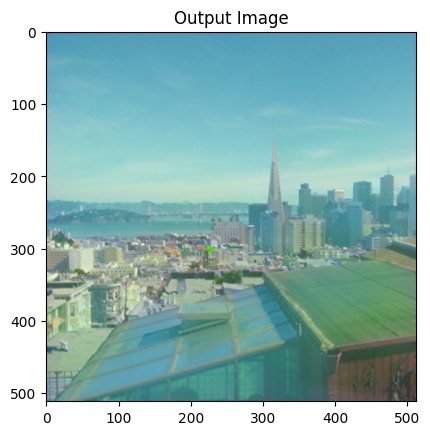

In [33]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps = 500, style_weight= 100000, content_weight= 1)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()